<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cat-vs.-Dog-Image-Classification" data-toc-modified-id="Cat-vs.-Dog-Image-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cat vs. Dog Image Classification</a></span><ul class="toc-item"><li><span><a href="#Exercise-1:-Building-a-Convnet-from-Scratch" data-toc-modified-id="Exercise-1:-Building-a-Convnet-from-Scratch-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exercise 1: Building a Convnet from Scratch</a></span></li><li><span><a href="#Explore-the-Example-Data" data-toc-modified-id="Explore-the-Example-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Explore the Example Data</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Using-row-Resnet" data-toc-modified-id="Using-row-Resnet-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Using row Resnet</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Train</a></span></li></ul></li></ul></div>

# Cat vs. Dog Image Classification

## Exercise 1: Building a Convnet from Scratch
**_Estimated completion time: 20 minutes_**

In this exercise, we will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Use row Resnet
3. Evaluate training and validation accuracy

Let's go!

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `./data`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes..

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./data/cats_and_dogs_filtered.zip

In [ ]:
import zipfile

local_zip = './data/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data')
zip_ref.close()

The contents of the .zip are extracted to the base directory `./data`, which contains `train` and `validation` subdirectories for the training and validation datasets, which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [2]:
base_dir = './data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [3]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])

['cat.127.jpg', 'cat.126.jpg', 'cat.125.jpg', 'cat.124.jpg', 'cat.123.jpg', 'cat.122.jpg', 'cat.121.jpg', 'cat.120.jpg', 'cat.119.jpg', 'cat.118.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [4]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

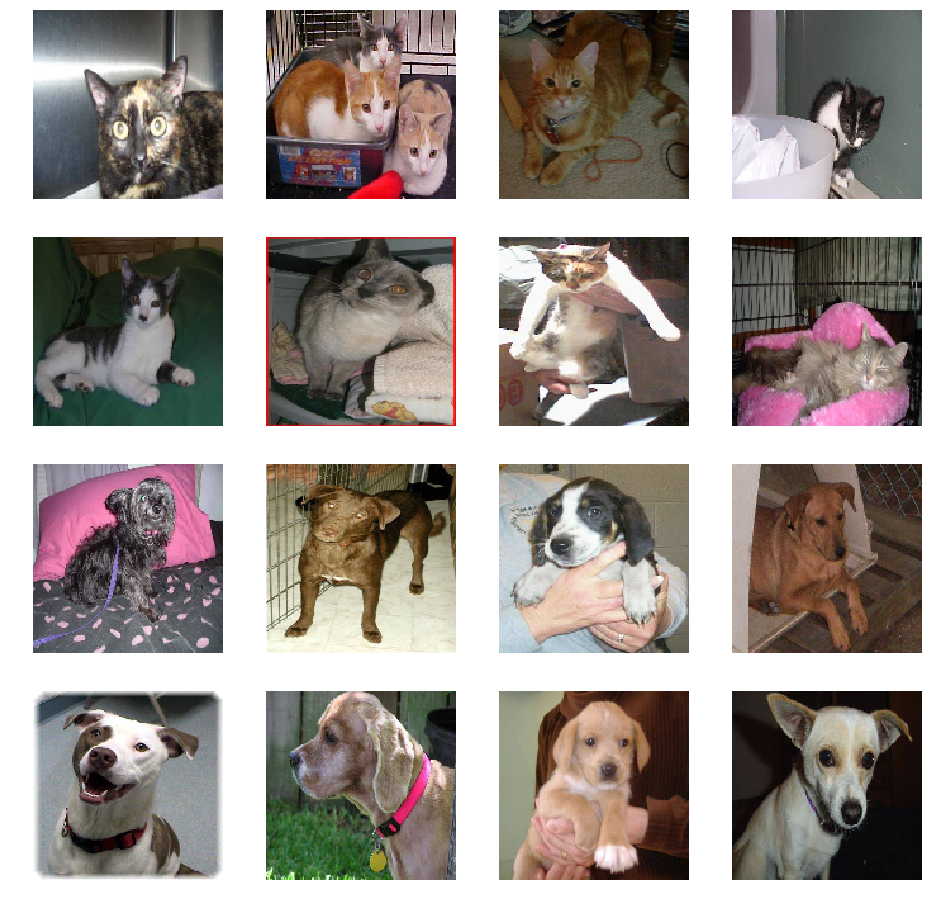

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img =load_img(img_path, target_size=(150, 150))
  plt.imshow(img)

plt.show()

## Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Using row Resnet

In [8]:
from  tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout

resnet = ResNet50(include_top=False, weights=None,  input_shape=(150,150,3),pooling = 'avg')


In [9]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
x=Dropout(0.2)(resnet.output)
new_output=Dense(1,activation='sigmoid')(x)
new_model=Model(resnet.input,new_output)

In [11]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
new_model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

## Train
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

In [13]:
history = new_model.fit_generator(
    train_generator, 
    epochs=100,
    validation_data=validation_generator,
    workers=8)

Epoch 1/100
20/20 [==============================] - 32s 2s/step - loss: 1.1808 - acc: 0.4725 - val_loss: 8.3809 - val_acc: 0.4760
Epoch 2/100
20/20 [==============================] - 10s 479ms/step - loss: 0.7946 - acc: 0.6150 - val_loss: 7.7436 - val_acc: 0.5020
Epoch 3/100
20/20 [==============================] - 10s 484ms/step - loss: 0.6045 - acc: 0.7140 - val_loss: 4.4848 - val_acc: 0.5060
Epoch 4/100
20/20 [==============================] - 10s 480ms/step - loss: 0.5448 - acc: 0.7590 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
20/20 [==============================] - 10s 483ms/step - loss: 0.5930 - acc: 0.7450 - val_loss: 8.0548 - val_acc: 0.5000
Epoch 6/100
20/20 [==============================] - 10s 483ms/step - loss: 0.4339 - acc: 0.8635 - val_loss: 6.5328 - val_acc: 0.5080
Epoch 7/100
20/20 [==============================] - 9s 472ms/step - loss: 0.4971 - acc: 0.7970 - val_loss: 2.3447 - val_acc: 0.5360
Epoch 8/100
20/20 [==============================] - 10s 489ms/ste

Let's plot the training and validation loss and accuracy to show it conclusively:

Text(0.5, 1.0, 'Training and validation loss')

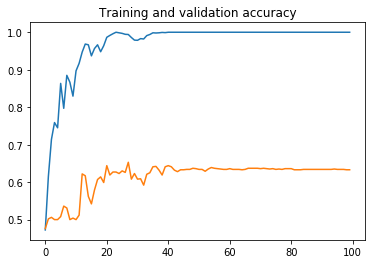

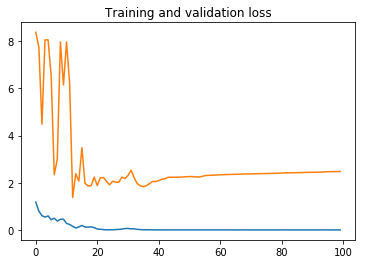

In [14]:

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss,label='val_loss')
plt.title('Training and validation loss')

In [15]:
import numpy as np
np.max(history.history['val_acc'])

0.652999997138977